In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root=".", train=True, transform=transform, download=True)
test_ds = datasets.MNIST(root=".", train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:03<00:00, 2492209.17it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 71965.79it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1072589.75it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4534760.48it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [4]:
def train(model, loader):
    model.train()
    for epoch in range(3):
        total = 0
        for x, y in loader:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total/len(loader):.4f}")

train(model, train_loader)

Epoch 1: Loss = 0.3568
Epoch 2: Loss = 0.1548
Epoch 3: Loss = 0.1070


In [5]:
def get_logits_labels(model, loader):
    model.eval()
    logits_list, labels_list = [], []
    with torch.no_grad():
        for x, y in loader:
            logits = model(x)
            logits_list.append(logits)
            labels_list.append(y)
    return torch.cat(logits_list), torch.cat(labels_list)

test_logits, test_labels = get_logits_labels(model, test_loader)

In [6]:
def softmax_temperature(logits, T):
    return F.softmax(logits / T, dim=1)

In [7]:
def entropy(p):
    return -(p * torch.log(p + 1e-8)).sum(dim=1)

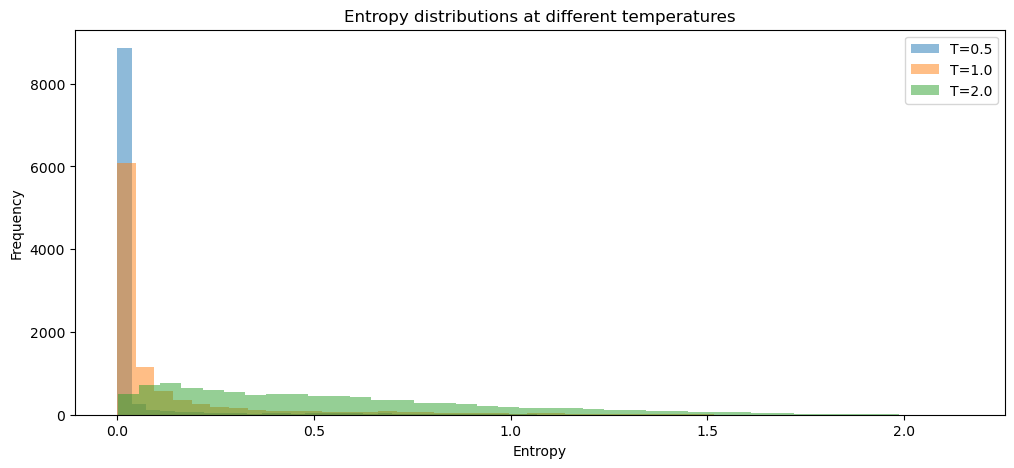

In [8]:
temperatures = [0.5, 1.0, 2.0]

plt.figure(figsize=(12, 5))
for T in temperatures:
    probs = softmax_temperature(test_logits, T)
    ent = entropy(probs).numpy()

    plt.hist(ent, bins=40, alpha=0.5, label=f"T={T}")

plt.title("Entropy distributions at different temperatures")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [11]:
def plot_reliability_multiclass(probs, labels, title):
    # Predicted probability = max softmax probability
    confidences = probs.max(dim=1).values.numpy()

    # Binary outcome: was the top prediction correct?
    predictions = probs.argmax(dim=1).numpy()
    correctness = (predictions == labels.numpy()).astype(int)

    # Now correctness is {0,1} → Binary → Valid for calibration_curve
    frac_pos, mean_pred = calibration_curve(
        correctness,
        confidences,
        n_bins=15,
        strategy="quantile"
    )

    plt.plot(mean_pred, frac_pos, marker='o')
    plt.plot([0, 1], [0, 1], "--")
    plt.title(title)
    plt.xlabel("Predicted confidence")
    plt.ylabel("True accuracy")
    plt.show()

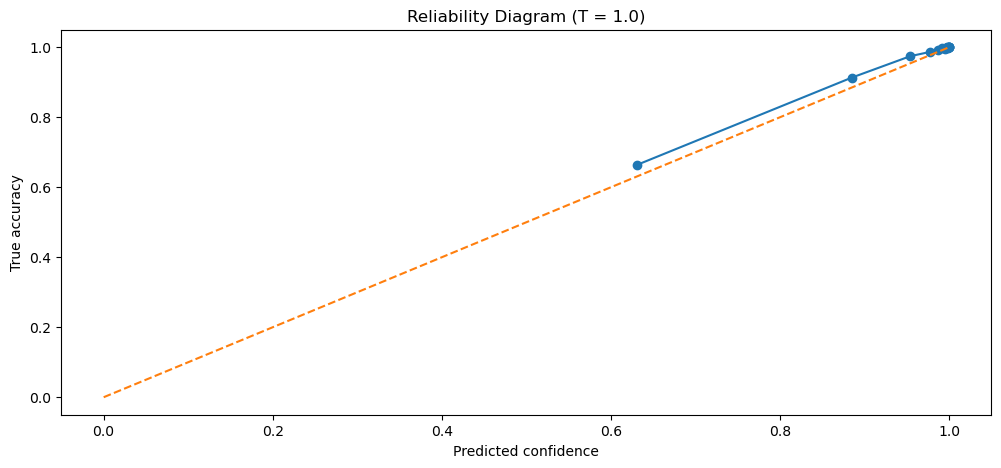

In [12]:
plt.figure(figsize=(12,5))
plot_reliability_multiclass(
    softmax_temperature(test_logits, 1.0),
    test_labels,
    "Reliability Diagram (T = 1.0)"
)


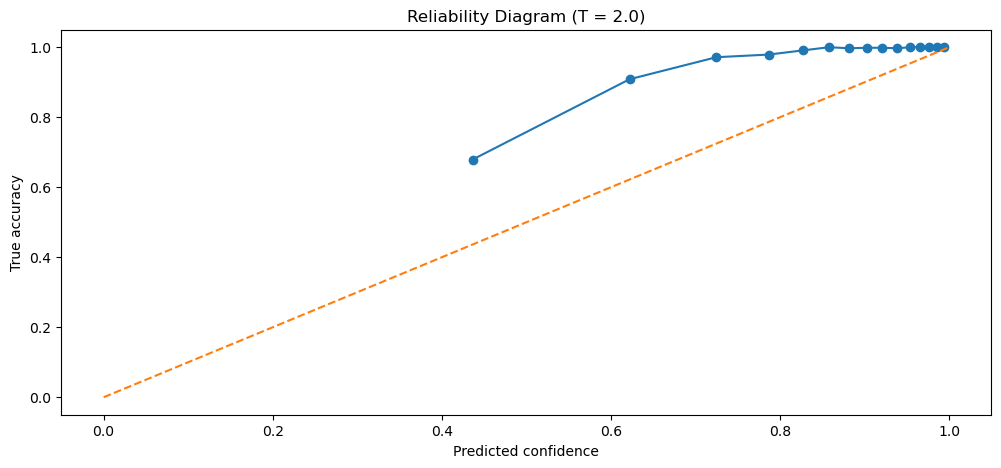

In [13]:
plt.figure(figsize=(12,5))
plot_reliability_multiclass(
    softmax_temperature(test_logits, 2.0),
    test_labels,
    "Reliability Diagram (T = 2.0)"
)


In [14]:
print("\nDone! You can now visually compare:")
print("1. Entropy changes across temperatures.")
print("2. Calibration curves for temperature scaling.")
print("3. How temperature affects confidence and calibration.\n")


Done! You can now visually compare:
1. Entropy changes across temperatures.
2. Calibration curves for temperature scaling.
3. How temperature affects confidence and calibration.

